In [18]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(0)   
tf.random.set_seed(0)

In [19]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [21]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [22]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [23]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[0:53199] 
Y_train_SS = Y_train_SS[0:53199]
Y_train_V = Y_train_V[0:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 52989
Validation samples: 7570
Testing samples: 15140


In [24]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [25]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [26]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [27]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 52989 samples, validate on 7570 samples
Epoch 1/100
52640/52989 [============================>.] - ETA: 0s - loss: 0.0262 - dense_12_loss: 0.0207 - dense_13_loss: 0.0054 - dense_12_mse: 0.0207 - dense_13_mse: 0.0054

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02501, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 112us/sample - loss: 0.0261 - dense_12_loss: 0.0207 - dense_13_loss: 0.0054 - dense_12_mse: 0.0207 - dense_13_mse: 0.0054 - val_loss: 0.0250 - val_dense_12_loss: 0.0187 - val_dense_13_loss: 0.0063 - val_dense_12_mse: 0.0187 - val_dense_13_mse: 0.0063
Epoch 2/100
52448/52989 [============================>.] - ETA: 0s - loss: 0.0118 - dense_12_loss: 0.0088 - dense_13_loss: 0.0030 - dense_12_mse: 0.0088 - dense_13_mse: 0.0030
Epoch 2: val_loss improved from 0.02501 to 0.02290, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 106us/sample - loss: 0.0118 - dense_12_loss: 0.0088 - dense_13_loss: 0.0030 - dense_12_mse: 0.0088 - dense_13_mse: 0.0030 - val_loss: 0.0229 - val_dense_12_loss: 0.0174 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0174 - val_dense_13_mse: 0.0055
Epoch 3/100
52672/52989 [============================>.] - ETA: 0s - loss: 0.0109 - dense_12_loss: 0.0080 - dense_13_loss: 0.0029 - dense_12_mse: 0.0080 - dense_13_mse: 0.0029
Epoch 3: val_loss improved from 0.02290 to 0.02102, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 110us/sample - loss: 0.0109 - dense_12_loss: 0.0080 - dense_13_loss: 0.0029 - dense_12_mse: 0.0080 - dense_13_mse: 0.0029 - val_loss: 0.0210 - val_dense_12_loss: 0.0156 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0156 - val_dense_13_mse: 0.0054
Epoch 4/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0101 - dense_12_loss: 0.0074 - dense_13_loss: 0.0027 - dense_12_mse: 0.0074 - dense_13_mse: 0.0027
Epoch 4: val_loss improved from 0.02102 to 0.01763, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 99us/sample - loss: 0.0101 - dense_12_loss: 0.0074 - dense_13_loss: 0.0027 - dense_12_mse: 0.0074 - dense_13_mse: 0.0027 - val_loss: 0.0176 - val_dense_12_loss: 0.0127 - val_dense_13_loss: 0.0049 - val_dense_12_mse: 0.0127 - val_dense_13_mse: 0.0049
Epoch 5/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0082 - dense_12_loss: 0.0059 - dense_13_loss: 0.0022 - dense_12_mse: 0.0059 - dense_13_mse: 0.0022
Epoch 5: val_loss improved from 0.01763 to 0.01391, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 108us/sample - loss: 0.0082 - dense_12_loss: 0.0059 - dense_13_loss: 0.0022 - dense_12_mse: 0.0059 - dense_13_mse: 0.0022 - val_loss: 0.0139 - val_dense_12_loss: 0.0098 - val_dense_13_loss: 0.0041 - val_dense_12_mse: 0.0098 - val_dense_13_mse: 0.0041
Epoch 6/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0057 - dense_12_loss: 0.0042 - dense_13_loss: 0.0015 - dense_12_mse: 0.0042 - dense_13_mse: 0.0015
Epoch 6: val_loss improved from 0.01391 to 0.00979, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 116us/sample - loss: 0.0057 - dense_12_loss: 0.0042 - dense_13_loss: 0.0015 - dense_12_mse: 0.0042 - dense_13_mse: 0.0015 - val_loss: 0.0098 - val_dense_12_loss: 0.0071 - val_dense_13_loss: 0.0027 - val_dense_12_mse: 0.0071 - val_dense_13_mse: 0.0027
Epoch 7/100
52989/52989 [==============================] - ETA: 0s - loss: 0.0047 - dense_12_loss: 0.0035 - dense_13_loss: 0.0012 - dense_12_mse: 0.0035 - dense_13_mse: 0.0012
Epoch 7: val_loss improved from 0.00979 to 0.00808, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 6s 107us/sample - loss: 0.0047 - dense_12_loss: 0.0035 - dense_13_loss: 0.0012 - dense_12_mse: 0.0035 - dense_13_mse: 0.0012 - val_loss: 0.0081 - val_dense_12_loss: 0.0061 - val_dense_13_loss: 0.0020 - val_dense_12_mse: 0.0060 - val_dense_13_mse: 0.0020
Epoch 8/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0040 - dense_12_loss: 0.0030 - dense_13_loss: 0.0010 - dense_12_mse: 0.0030 - dense_13_mse: 0.0010
Epoch 8: val_loss improved from 0.00808 to 0.00627, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 101us/sample - loss: 0.0040 - dense_12_loss: 0.0030 - dense_13_loss: 0.0010 - dense_12_mse: 0.0030 - dense_13_mse: 0.0010 - val_loss: 0.0063 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0016 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0016
Epoch 9/100
52288/52989 [============================>.] - ETA: 0s - loss: 0.0037 - dense_12_loss: 0.0027 - dense_13_loss: 9.6617e-04 - dense_12_mse: 0.0027 - dense_13_mse: 9.6617e-04
Epoch 9: val_loss improved from 0.00627 to 0.00584, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 103us/sample - loss: 0.0037 - dense_12_loss: 0.0027 - dense_13_loss: 9.6571e-04 - dense_12_mse: 0.0027 - dense_13_mse: 9.6560e-04 - val_loss: 0.0058 - val_dense_12_loss: 0.0043 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0043 - val_dense_13_mse: 0.0016
Epoch 10/100
52320/52989 [============================>.] - ETA: 0s - loss: 0.0035 - dense_12_loss: 0.0025 - dense_13_loss: 9.0982e-04 - dense_12_mse: 0.0025 - dense_13_mse: 9.0982e-04
Epoch 10: val_loss did not improve from 0.00584
52989/52989 [==============================] - 4s 81us/sample - loss: 0.0035 - dense_12_loss: 0.0026 - dense_13_loss: 9.1030e-04 - dense_12_mse: 0.0026 - dense_13_mse: 9.1035e-04 - val_loss: 0.0105 - val_dense_12_loss: 0.0076 - val_dense_13_loss: 0.0029 - val_dense_12_mse: 0.0076 - val_dense_13_mse: 0.0029
Epoch 11/100
52320/52989 [============================>.] - ETA: 0s - loss: 0.0033 - dense_12_loss: 0.0024 - dense_13_loss: 8.8830e-04 - dense_12_mse:

52989/52989 [==============================] - 6s 112us/sample - loss: 0.0033 - dense_12_loss: 0.0024 - dense_13_loss: 8.8847e-04 - dense_12_mse: 0.0024 - dense_13_mse: 8.8852e-04 - val_loss: 0.0049 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 0.0013 - val_dense_12_mse: 0.0037 - val_dense_13_mse: 0.0012
Epoch 12/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0029 - dense_12_loss: 0.0022 - dense_13_loss: 7.7588e-04 - dense_12_mse: 0.0022 - dense_13_mse: 7.7588e-04
Epoch 12: val_loss did not improve from 0.00491
52989/52989 [==============================] - 4s 79us/sample - loss: 0.0029 - dense_12_loss: 0.0022 - dense_13_loss: 7.7598e-04 - dense_12_mse: 0.0022 - dense_13_mse: 7.7602e-04 - val_loss: 0.0059 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0012
Epoch 13/100
52989/52989 [==============================] - ETA: 0s - loss: 0.0029 - dense_12_loss: 0.0022 - dense_13_loss: 7.6646e-04 - dense_12_mse:

52989/52989 [==============================] - 6s 119us/sample - loss: 0.0026 - dense_12_loss: 0.0020 - dense_13_loss: 6.7781e-04 - dense_12_mse: 0.0020 - dense_13_mse: 6.7782e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 0.0010 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 0.0010
Epoch 16/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0025 - dense_12_loss: 0.0019 - dense_13_loss: 6.3812e-04 - dense_12_mse: 0.0019 - dense_13_mse: 6.3812e-04
Epoch 16: val_loss did not improve from 0.00423
52989/52989 [==============================] - 4s 73us/sample - loss: 0.0025 - dense_12_loss: 0.0019 - dense_13_loss: 6.4543e-04 - dense_12_mse: 0.0019 - dense_13_mse: 6.4542e-04 - val_loss: 0.0048 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0012
Epoch 17/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0025 - dense_12_loss: 0.0019 - dense_13_loss: 6.1783e-04 - dense_12_mse:

52989/52989 [==============================] - 5s 103us/sample - loss: 0.0024 - dense_12_loss: 0.0018 - dense_13_loss: 5.8459e-04 - dense_12_mse: 0.0018 - dense_13_mse: 5.8462e-04 - val_loss: 0.0041 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 7.9115e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 7.9258e-04
Epoch 20/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0024 - dense_12_loss: 0.0018 - dense_13_loss: 5.9418e-04 - dense_12_mse: 0.0018 - dense_13_mse: 5.9418e-04
Epoch 20: val_loss did not improve from 0.00414
52989/52989 [==============================] - 4s 77us/sample - loss: 0.0024 - dense_12_loss: 0.0018 - dense_13_loss: 5.9272e-04 - dense_12_mse: 0.0018 - dense_13_mse: 5.9275e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 9.4976e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 9.4912e-04
Epoch 21/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0017 - dense_13_loss: 5.4772e-04

52989/52989 [==============================] - 6s 105us/sample - loss: 0.0021 - dense_12_loss: 0.0016 - dense_13_loss: 5.0902e-04 - dense_12_mse: 0.0016 - dense_13_mse: 5.0904e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0028 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0028 - val_dense_13_mse: 0.0011
Epoch 28/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0015 - dense_13_loss: 4.7973e-04 - dense_12_mse: 0.0015 - dense_13_mse: 4.7973e-04
Epoch 28: val_loss did not improve from 0.00390
52989/52989 [==============================] - 4s 77us/sample - loss: 0.0019 - dense_12_loss: 0.0015 - dense_13_loss: 4.7823e-04 - dense_12_mse: 0.0015 - dense_13_mse: 4.7825e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 9.4846e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 9.5017e-04
Epoch 29/100
52800/52989 [============================>.] - ETA: 0s - loss: 0.0020 - dense_12_loss: 0.0015 - dense_13_loss: 4.9457e-04 - dense

52989/52989 [==============================] - 6s 111us/sample - loss: 0.0020 - dense_12_loss: 0.0015 - dense_13_loss: 4.9328e-04 - dense_12_mse: 0.0015 - dense_13_mse: 4.9330e-04 - val_loss: 0.0038 - val_dense_12_loss: 0.0030 - val_dense_13_loss: 8.5621e-04 - val_dense_12_mse: 0.0030 - val_dense_13_mse: 8.5705e-04
Epoch 30/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 4.6835e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.6835e-04
Epoch 30: val_loss did not improve from 0.00381
52989/52989 [==============================] - 4s 74us/sample - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 4.6797e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.6799e-04 - val_loss: 0.0046 - val_dense_12_loss: 0.0030 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0030 - val_dense_13_mse: 0.0015
Epoch 31/100
52672/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0015 - dense_13_loss: 4.8463e-04 - dense

52989/52989 [==============================] - 6s 121us/sample - loss: 0.0018 - dense_12_loss: 0.0014 - dense_13_loss: 4.6288e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.6265e-04 - val_loss: 0.0037 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 5.9010e-04 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 5.9115e-04
Epoch 39/100
52832/52989 [============================>.] - ETA: 0s - loss: 0.0016 - dense_12_loss: 0.0012 - dense_13_loss: 4.1115e-04 - dense_12_mse: 0.0012 - dense_13_mse: 4.1115e-04
Epoch 39: val_loss did not improve from 0.00372
52989/52989 [==============================] - 4s 74us/sample - loss: 0.0016 - dense_12_loss: 0.0012 - dense_13_loss: 4.1159e-04 - dense_12_mse: 0.0012 - dense_13_mse: 4.1161e-04 - val_loss: 0.0044 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 0.0013 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 0.0013
Epoch 40/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.4317e-04 - dense

52989/52989 [==============================] - 6s 108us/sample - loss: 0.0017 - dense_12_loss: 0.0012 - dense_13_loss: 4.1672e-04 - dense_12_mse: 0.0012 - dense_13_mse: 4.1675e-04 - val_loss: 0.0035 - val_dense_12_loss: 0.0028 - val_dense_13_loss: 6.4258e-04 - val_dense_12_mse: 0.0028 - val_dense_13_mse: 6.4372e-04
Epoch 43/100
52704/52989 [============================>.] - ETA: 0s - loss: 0.0017 - dense_12_loss: 0.0012 - dense_13_loss: 4.1331e-04 - dense_12_mse: 0.0012 - dense_13_mse: 4.1331e-04
Epoch 43: val_loss did not improve from 0.00347
52989/52989 [==============================] - 4s 76us/sample - loss: 0.0017 - dense_12_loss: 0.0012 - dense_13_loss: 4.1250e-04 - dense_12_mse: 0.0012 - dense_13_mse: 4.1252e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 6.6139e-04 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 6.6227e-04
Epoch 44/100
52960/52989 [============================>.] - ETA: 0s - loss: 0.0016 - dense_12_loss: 0.0012 - dense_13_loss: 4.0306e-04

52989/52989 [==============================] - 5s 98us/sample - loss: 0.0016 - dense_12_loss: 0.0012 - dense_13_loss: 3.8516e-04 - dense_12_mse: 0.0012 - dense_13_mse: 3.8518e-04 - val_loss: 0.0033 - val_dense_12_loss: 0.0028 - val_dense_13_loss: 5.7846e-04 - val_dense_12_mse: 0.0028 - val_dense_13_mse: 5.7944e-04
Epoch 46/100
52256/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_12_loss: 0.0011 - dense_13_loss: 3.7683e-04 - dense_12_mse: 0.0011 - dense_13_mse: 3.7683e-04
Epoch 46: val_loss did not improve from 0.00335
52989/52989 [==============================] - 4s 75us/sample - loss: 0.0015 - dense_12_loss: 0.0011 - dense_13_loss: 3.7515e-04 - dense_12_mse: 0.0011 - dense_13_mse: 3.7517e-04 - val_loss: 0.0045 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 0.0013 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 0.0013
Epoch 47/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0015 - dense_12_loss: 0.0012 - dense_13_loss: 3.8057e-04 - dense_

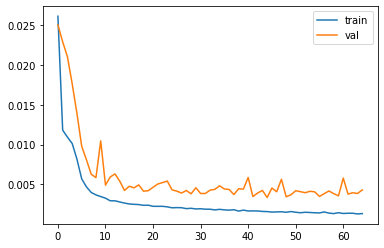

---Training time: 297.36220622 seconds ---


In [28]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [29]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.95602, Train (V) - 0.89660
R2 scores: Validation (SS) - 0.90525, Validation (V) - 0.89821
R2 scores: Testing (SS) - 0.75418, Testing (V) - 0.70626
RMSE scores: Train (SS) - 0.03124, Train (V) - 0.01748
RMSE scores: Validation (SS) - 0.06113, Validation (V) - 0.02373
RMSE scores: Testing (SS) - 0.10672, Testing (V) - 0.04623


In [30]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [31]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

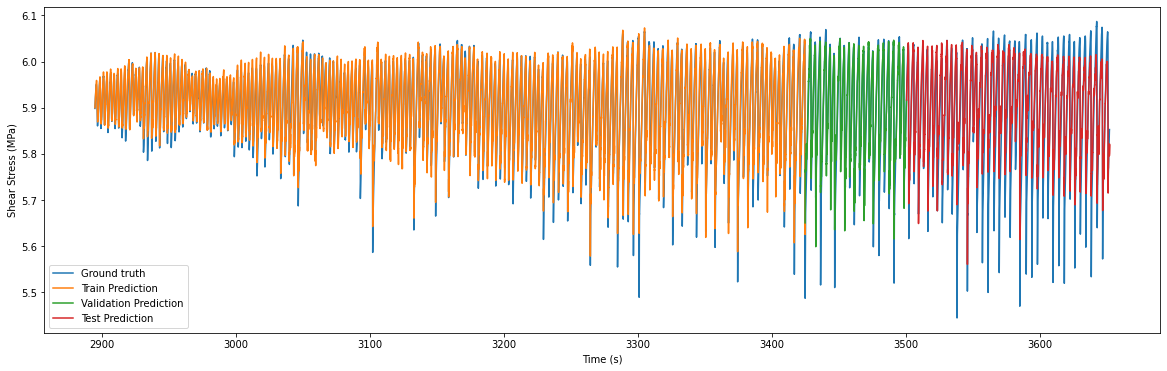

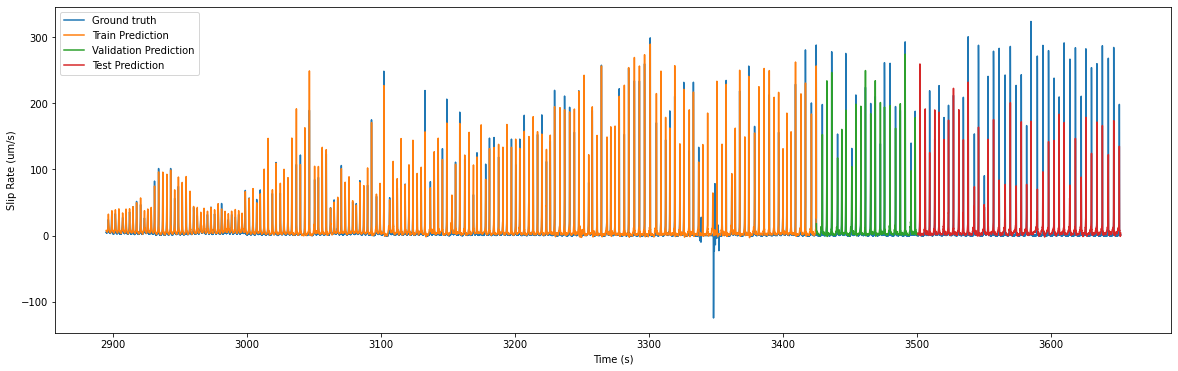

In [32]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

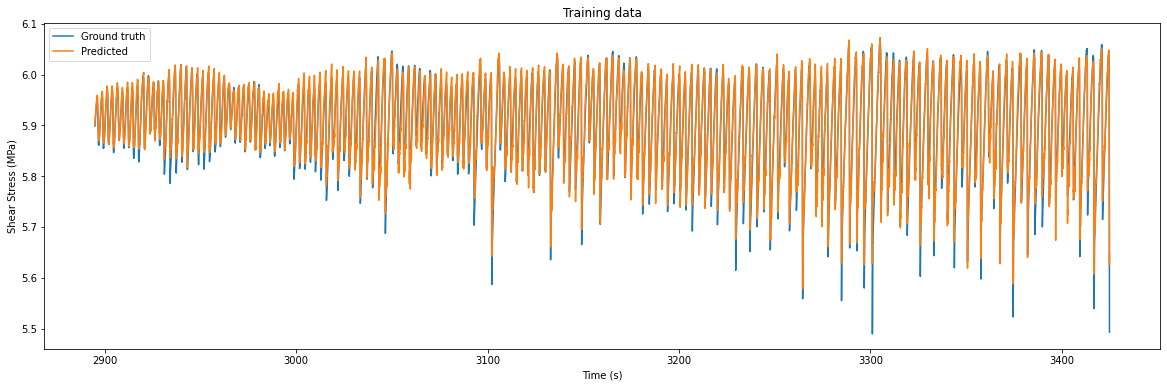

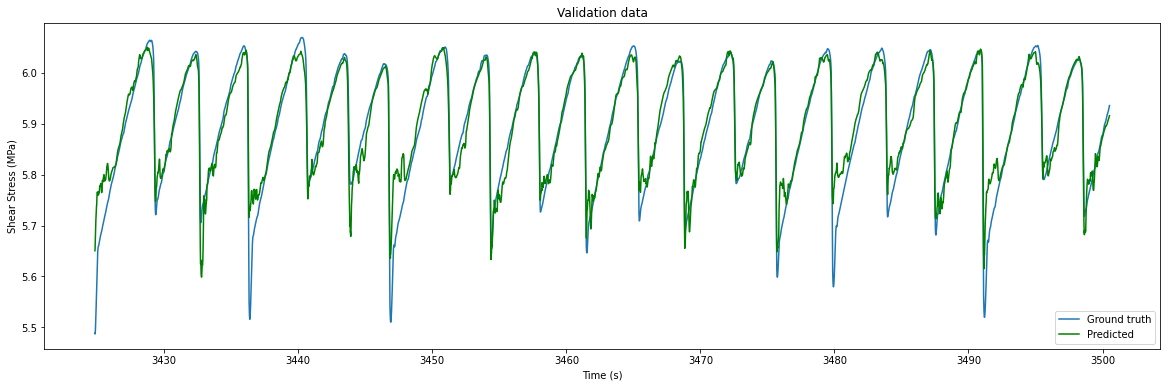

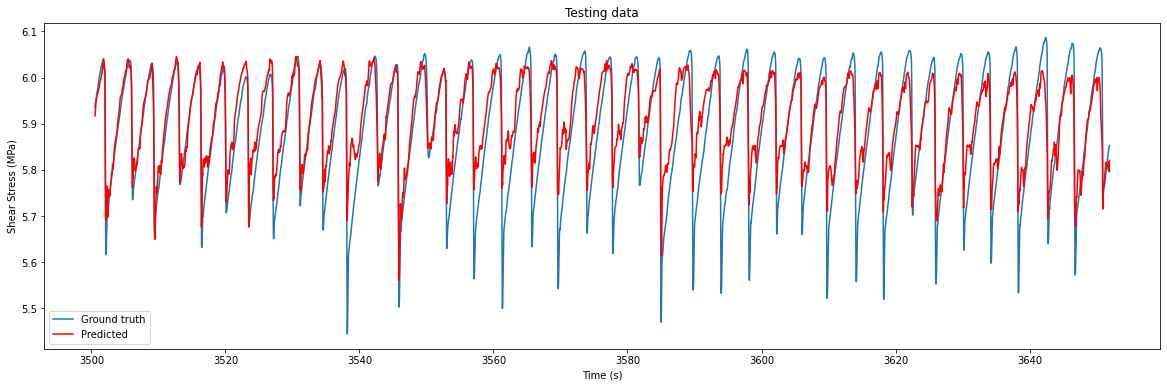

In [33]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

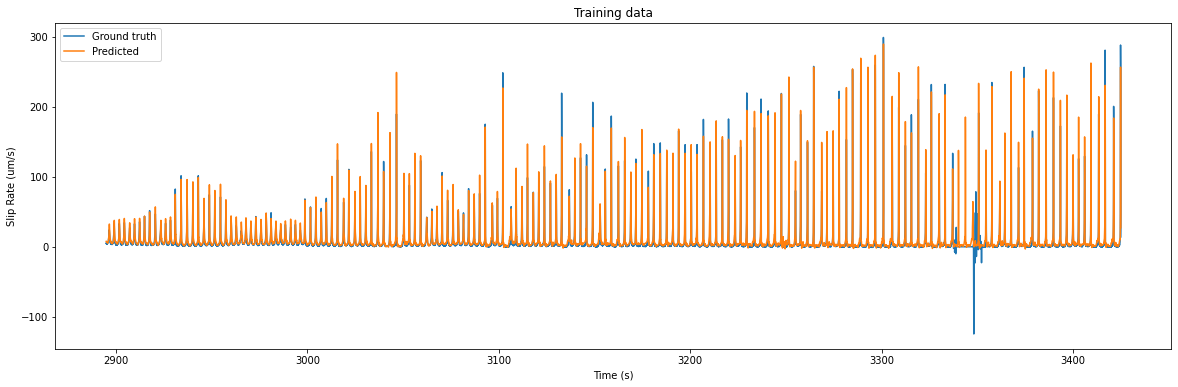

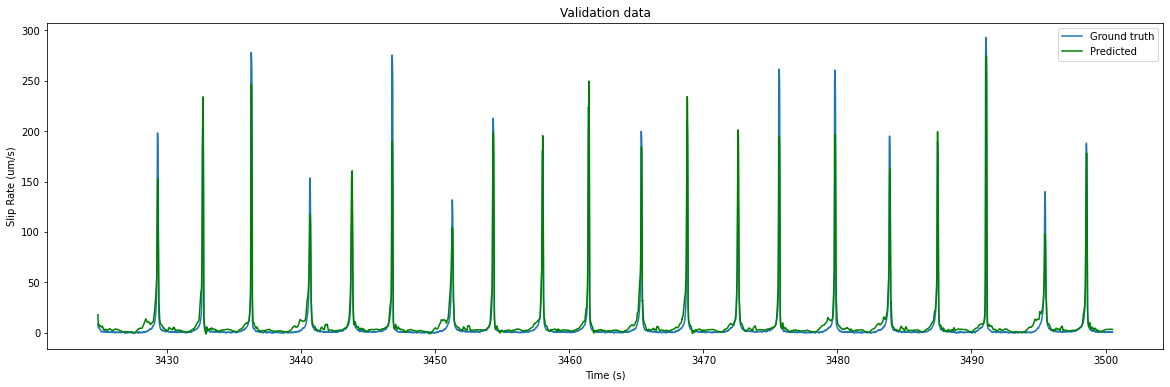

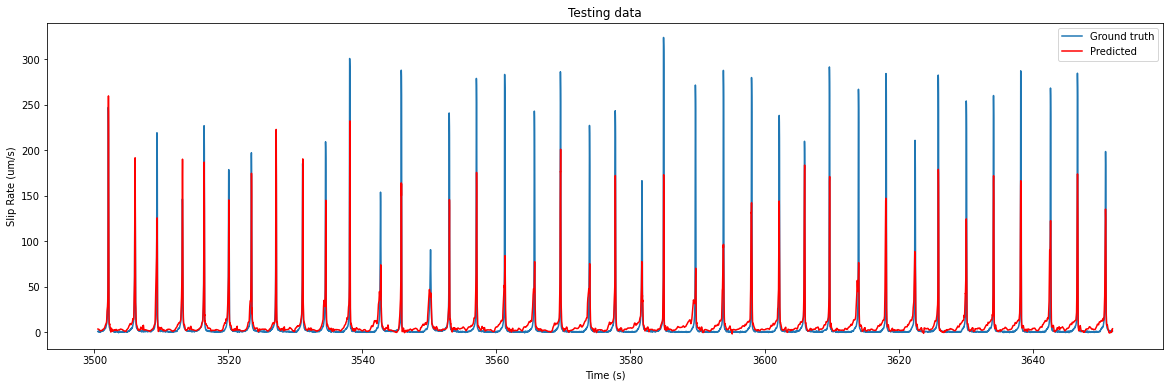

In [34]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')